# ΔΔG Exercise

A classical technique in protein biochemisty and protein engineering is to describe a mutant protein sequence in terms of a "ΔΔG": the change in free energy of a protein upon mutation. This formalism has been especially useful in many applications, such as identifying stabilizing mutations for industrial protein engineering applications, or identifying "hot spot" residues in protein-protein interaction interfaces that contribute most of the energy to binding.

Computing changes of free energy is at the core of the design functionality in Rosetta, since we undergo a design simulation by choosing mutations (sampling) and seeing whether they improve the predicted energy of the structure (scoring). In this exercise, we will see how close we can get with predicting the ΔΔG of mutations in a well-studied monomeric protein, lysozyme. We will try to compute a ΔΔG in a couple of ways, and at each step compare the predictions with the experimentally measured ΔΔG.

The files for this exercise are found at https://github.com/Kortemme-Lab/protein_design_course_files/tree/master/ddg_exercise

If you have already git installed the `protein_design_course_files` repository, please update it with

```
cd /path/to/protein_design_course_files
git pull
cd ddg_exercise
```

If you need to install the repository for the first time, run

```
git clone https://github.com/Kortemme-Lab/protein_design_course_files.git
cd protein_design_course_files
cd ddg_exercise
```

Remember to initialize your conda environment with: `conda activate proteindesign` and also open a PyMOL session.

For this exercise, you can open the jupyter notebook to run the code by typing `jupyter notebook`, or you can copy-paste each chunk into a python console, which you initiate by typing `python` or `ipython`.

As always, we start by initializing our PyRosetta session with an `init` call.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import pyrosetta
from pyrosetta import *
pyrosetta.init('''
               -ex1
               -ex2
               -score:weights ref2015_cart
               -use_input_sc
               -ignore_unrecognized_res           
               ''')
from pyrosetta.rosetta.core.pack.task import TaskFactory
from pyrosetta.rosetta.core.pack.task import operation
from pyrosetta.rosetta.core.select import residue_selector

scorefxn = create_score_function('ref2015_cart')

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python38.mac 2020.28+release.8ecab77aa50ac1301efe53641e07e09ac91fee3b 2020-07-07T16:41:06] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python38.mac r260 2020.28+release.8ecab77aa50 8ecab77aa50ac1301efe53641e07e09ac91fee3b http://www.pyrosetta.org 2020-07-07T16:41:06
core.init: command: PyRosetta -ex1 -ex2 -score:weights ref2015_cart -use_input_sc -ignore_unrecognized_res -database /Users/cjmathy/.pyenv/versions/3.8.4/lib/python3.8/site-packages/pyrosetta-2020.28+release.8ecab77aa50-py3.8-macosx-10.15-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=226263119 seed_offset=0 real_seed=226263119
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=

Let's also load in the experimentally measured ΔΔG's so we have them for comparison to our calculated ΔΔG's. We will use a dataset derived from the public ProTherm database (https://www.iitm.ac.in/bioinfo/ProTherm/). This dataset was curated to include high-quality measurements for use in benchmarking computational ΔΔG protocols (described at https://doi.org/10.1371/journal.pone.0130433).

If you're curious about the types of studies that generate this data, here's a good example: https://pubmed.ncbi.nlm.nih.gov/1911773/.

In [2]:
# %%
# function to convert 'A G 44 S' format (chain aa_from position aa_to) to G44S
# for curated_protherm datasets
def convert_mutation_format(s):
    vec = re.split(r' |_', s)
    if len(vec) == 4:
        return ''.join(vec[1:])
    if len(vec) == 8:
        return ''.join(vec[1:4])+'/'+''.join(vec[5:8])

# read only the lysozyme mutants (PDB 1L63) from the protherm dataset
pt = (pd.read_csv('~/lab/gsp1_ddg/benchmarking/datasets/curatedprotherm.csv', header=19)
      .loc[lambda df: df.PDBFileID == '1L63']
      .loc[lambda df: df.DSSPSimpleTypes.apply(len) == 1]  # ignore records w/ >1 mutation
      .assign(chain = lambda df: df.Mutations.apply(lambda row: row[0]),
              mutation_short = lambda df: df.Mutations.apply(lambda row: convert_mutation_format(row)),
              position = lambda df: df.mutation_short.apply(lambda i: int(i[1:-1])),
              aa_to = lambda df: df.mutation_short.apply(lambda i: i[-1])
              )
      .rename(columns={'RecordID':'protherm_ID','PDBFileID':'pdb', 'Mutations':'mutation',
                      'DDG':'ddg_expt', 'IndividualDDGs':'ddg_expt_individ'})
      [['pdb','mutation','chain','mutation_short','position','protherm_ID','ddg_expt','ddg_expt_individ']]
)

pt[(pt.position == 99) & (pt.pdb == '1L63')]


,pdb,mutation,chain,mutation_short,position,protherm_ID,ddg_expt,ddg_expt_individ
1037,1L63,A L 99 A,A,L99A,99,814,4.533333,5.0_5.0_4.5_4.6_4.0_4.1
1038,1L63,A L 99 F,A,L99F,99,903,0.330000,0.36_0.3
1039,1L63,A L 99 G,A,L99G,99,866,6.850000,7.4_6.3
1040,1L63,A L 99 I,A,L99I,99,884,1.450000,1.4_1.5
1041,1L63,A L 99 M,A,L99M,99,914,0.583333,0.4_0.75_0.6
1042,1L63,A L 99 V,A,L99V,99,863,2.135000,2.27_2.0


I've pre-relaxed the starting crystal structure for you to save some time. If you'd like to run Relax yourself, feel free to run the script in the directory with the command below. It should take about 10 minutes

```
python relax_1L63.py
```

Next, load in our PDBs

In [3]:
pose = pose_from_pdb('1l63_clean.pdb')
pose.pdb_info().name('1l63_xtal')
pose_relaxed = pose_from_pdb('1l63_relaxed.pdb')
pose_relaxed.pdb_info().name('1l63_relaxed')

core.import_pose.import_pose: File '1l63_clean.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 162
core.import_pose.import_pose: File '1l63_relaxed.pdb' automatically determined to be of type PDB


In [4]:
pmm = PyMOLMover()
pmm.apply(pose_relaxed)

In PyMOL, copy and paste the following commands to show the core packing around Leu 99.

`util.cbaw 1l63_relaxed`

`select core, 1l63_relaxed and br. (sc.  within 3 of (resi 99 and sc.))`

`util.cbac core`

`util.cbas core and resi 99`

`show spheres, core`

`set_view (\
     0.749474406,   -0.659760594,   -0.054414708,\
    -0.335082650,   -0.448958933,    0.828328848,\
    -0.570924938,   -0.602581918,   -0.557566702,\
     0.000094488,    0.001106668,  -85.698837280,\
    30.798748016,    4.481562614,    6.916054726,\
    49.036270142,  122.386810303,  -20.000000000 )`

`deselect`

You should see Leu 99 in pink in the center of the frame, well packed in the core of the protein. 

Now run the following commands to show sidechains as sticks instead of as spheres:

`hide spheres, core`

`show sticks, core and not hydro`

It should now be much easier to see how each of the sidechains in the residues shown are pointed inward to form the hydrophobic core of the protein. 

Next, we are going to compute the change in energy for when we mutating Leu 99 to a Phenylalanine, which has a large benzene ring as a sidechain. This mutant can be referred to as L99F.

In [5]:
pose_L99F = pose_relaxed.clone()
pose_L99F.pdb_info().name('L99F')

mutate_mover = pyrosetta.rosetta.protocols.simple_moves.MutateResidue()
mutate_mover.set_target(99)
mutate_mover.set_res_name('PHE')
mutate_mover.apply(pose_L99F)

# score WT and L99F mutant
WT_score = scorefxn(pose_relaxed)
L99F_score = scorefxn(pose_L99F)

print('\nWT score: ' + str(WT_score))
print('\nL99F score: ' + str(L99F_score))

core.scoring.CartesianBondedEnergy: Creating new peptide-bonded energy container (162)
basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/cjmathy/.pyenv/versions/3.8.4/lib/python3.8/site-packages/pyrosetta-2020.28+release.8ecab77aa50-py3.8-macosx-10.15-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/cjmathy/.pyenv/versions/3.8.4/lib/python3.8/site-packages/pyrosetta-2020.28+release.8ecab77aa50-py3.8-macosx-10.15-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.Rotamer

The score has jumped quite a bit! If we quantify by how much it has changed, we get the ΔΔG. That is, The ΔΔG of a mutation is defined as the difference in free energy of protein before and after mutation, or $ΔΔG_{MUTATION} = ΔG_{MUT} - ΔG_{\text{WT}}$

Since the Rosetta score function is meant to approximate energies, we can use it to compute a predicted ΔΔG of L99F. Note that the score is given in REU energy units. For this specific score function and application, assume that 1 REU is about 3-4 kcal/mol, so we will divide our difference in scores by 4. We then compare our computed ΔΔG to the measured ΔΔG from the ProTherm database.

In [6]:
scaling_factor_for_ddG = 4
ddG_L99F = L99F_score - WT_score
print('Difference in score L99F - WT: ' + str(ddG_L99F))
print('Computed ΔΔG of L99F: ' + str(ddG_L99F/scaling_factor_for_ddG))

L99F_ddG_measured = pt[pt.mutation == 'A L 99 F'].ddg_expt.values[0]
print('Measured ΔΔG of L99F: ' + str(L99F_ddG_measured))


Difference in score L99F - WT: 362.7177578506346
Computed ΔΔG of L99F: 90.67943946265865
Measured ΔΔG of L99F: 0.33


Unfortunately, we are off by two orders of magnitude. In fact, the experimental ΔΔG tells us that L99F is not a destabilizing mutation. First, let's examine why Rosetta thinks it should be destabilizing by looking at which energy terms changed.

In [7]:
energy_table_WT = pyrosetta.bindings.energies.residue_total_energies_array(pose_relaxed.energies())
energy_df_WT = pd.DataFrame(energy_table_WT)
totals_by_term_WT = energy_df_WT.sum(axis=0)


energy_table_L99F = pyrosetta.bindings.energies.residue_total_energies_array(pose_L99F.energies())
energy_df_L99F = pd.DataFrame(energy_table_L99F)
totals_by_term_L99F = energy_df_L99F.sum(axis=0)

totals_by_term_L99F - totals_by_term_WT

fa_atr                  -4.568252
fa_rep                 667.622239
fa_sol                  -0.383533
fa_intra_rep            -0.220956
fa_intra_sol_xover4      0.114745
lk_ball_wtd             -0.169003
fa_elec                 -0.639650
hbond_sr_bb              0.000000
hbond_lr_bb              0.000000
hbond_bb_sc              0.000000
hbond_sc                 0.000000
dslf_fa13                0.000000
omega                    0.000000
fa_dun                   1.912687
p_aa_pp                  0.404242
yhh_planarity            0.000000
ref                     -0.443180
rama_prepro              0.197129
cart_bonded             -0.389653
total_score            362.577561
dtype: float64

The energy term `fa_rep` showed a massive jump. This suggests that there are clashes in the structure, where atoms are too close to each other. This is what we expected, because we introduced a larger Phenylalanine side chain into the space previously occupied by the smaller Leucine, and the fit was already tight. We can visualize this in the structure. First send the mutated pose to PyMOL, then run the commands below it to visualize just the mutated pose.


In [8]:
pmm.apply(pose_L99F)

In PyMOL, copy and paste the following commands to visualize the clashes around the Phenylalanine introduced by the L99F mutation.

`util.cbaw L99F`

`select L99F_core, L99F and br. (sc.  within 3 of (resi 99 and sc.))`

`util.cbac L99F_core`

`util.cbas L99F_core and resi 99`

`show sticks, L99F_core and not hydro`

`show spheres, L99F and (resi 84 or resi 99) and not (name O or name N)`

`set_view (\
     0.969336450,   -0.243796781,   -0.030075530,\
    -0.183128297,   -0.798800588,    0.573020101,\
    -0.163719043,   -0.549941719,   -0.818962932,\
     0.000094488,    0.001106668,  -68.288848877,\
    30.798748016,    4.481562614,    6.916054726,\
    31.626289368,  104.976821899,  -20.000000000 )`

`deselect`

The pink Phenylalanine at position 99 is shoved into the space filled by Leucine 84! This is not an even remotely likely arrangement of atoms in nature, and Rosetta accordingly scores it very badly. So what have we done wrong when mutating L99F?

The small experimental ΔΔG tells us that the native state of the L99F mutant has a very similar (within 1 kcal/mol) energy to the wild type protein, which suggests that the sidechains that were densely packed around Leu 99 could in fact shift to accommodate a larger Phenylalanine. However, we did not instruct Rosetta to repack around the mutation. Repacking is the process of sampling different rotamers (side chain conformations) for the residues in contact with residue 99.

Let's repack any residues within 10 Angstroms.

In [9]:
# Select mutant position
mutant_position = residue_selector.ResidueIndexSelector()
mutant_position.set_index(99)

# Select neighbor positions
nbr_selector = residue_selector.NeighborhoodResidueSelector() 
nbr_selector.set_focus_selector(mutant_position)
nbr_selector.set_include_focus_in_subset(True)
nbr_selector.set_distance(10) # note default is 10, so could leave this out

# Make a task factory
tf = TaskFactory()
tf.push_back(operation.InitializeFromCommandline())
tf.push_back(operation.IncludeCurrent())
tf.push_back(operation.NoRepackDisulfides())

# Disable packing for all residues, then re-enable it for neigbor residues
prevent_repacking_rlt = operation.PreventRepackingRLT()
define_repacking = operation.OperateOnResidueSubset(prevent_repacking_rlt, nbr_selector, True )
tf.push_back(define_repacking)

# Disable design for the whole protein, since we only want to repack
not_design = residue_selector.TrueResidueSelector()
tf.push_back(operation.OperateOnResidueSubset(operation.RestrictToRepackingRLT(),not_design))

# Uncomment this command to see whether you set up the packer correctly
# print(tf.create_task_and_apply_taskoperations(pose_L99F))  

# # Create Packer
packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover()
packer.task_factory(tf)

In [10]:
# Run repacking
pose_L99F_repacked = pose_L99F.clone()
pose_L99F_repacked.pdb_info().name('L99F_repacked')

packer.apply(pose_L99F_repacked)

protocols.minimization_packing.PackRotamersMover: [ WARNING ] undefined ScoreFunction -- creating a default one
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015_cart
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 777 rotamers at 26 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph


In [11]:
L99F_repacked_score = scorefxn(pose_L99F_repacked)

print('\nWT score: ' + str(WT_score))
print('\nL99F mutated score: ' + str(L99F_score))
print('\nL99F repacked score: ' + str(L99F_repacked_score))

ddG_L99F = L99F_repacked_score - WT_score
print('\n\nDifference in score L99F (repacked) - WT: ' + str(ddG_L99F))
print('Computed ΔΔG of L99F: ' + str(ddG_L99F/scaling_factor_for_ddG))
print('Measured ΔΔG of L99F: ' + str(L99F_ddG_measured))


WT score: -594.2379820591656

L99F mutated score: -231.520224208531

L99F repacked score: -312.30548187189106


Difference in score L99F (repacked) - WT: 281.9325001872745
Computed ΔΔG of L99F: 70.48312504681863
Measured ΔΔG of L99F: 0.33


This is much better! but still off two an orders of magnitude. If we examine the structure, we see that just repacking was not enough to resolve the clash

In [12]:
pmm.apply(pose_L99F_repacked)

`util.cbaw L99F_repacked`

`select L99F_repacked_core, L99F_repacked and br. (sc.  within 3 of (resi 99 and sc.))`

`util.cbac L99F_repacked_core`

`util.cbas L99F_repacked_core and resi 99`

`show sticks, L99F_repacked_core and not hydro`

`# show spheres, L99F_repacked_core and (resi 84 or resi 99) and not (name O or name N)`

`set_view (\
     0.737348735,   -0.664588213,   -0.120811388,\
    -0.212751448,   -0.398235619,    0.892252982,\
    -0.641090214,   -0.632204175,   -0.435039639,\
     0.000094488,    0.001106668,  -85.698837280,\
    30.798748016,    4.481562614,    6.916054726,\
    49.036270142,  122.386810303,  -20.000000000 )`

`deselect`

This suggests that the backbone as it currently is modeled is just not capable of incorporating the large phenyl group. We must therefore introduce changes to the backbone to see if we can create some space. We can do this by adding a minimization step to our repacking. At this point, we are just running a round of relax while restricting repacking to the vicinity around the mutation.

In [13]:
# Create movemap factory
mmf = pyrosetta.rosetta.core.select.movemap.MoveMapFactory()
mmf.all_bb(setting=True)
mmf.all_bondangles(setting=True)
mmf.all_bondlengths(setting=True)
mmf.all_chi(setting=True)
mmf.all_jumps(setting=True)
mmf.set_cartesian(setting=True)

# Make fastrelax protocol
fr = pyrosetta.rosetta.protocols.relax.FastRelax(standard_repeats=1)
fr.set_scorefxn(scorefxn)
fr.set_task_factory(tf)
fr.set_movemap_factory(mmf)
fr.cartesian(True)
fr.min_type("lbfgs_armijo_nonmonotone")

pose_L99F_relaxed = pose_L99F.clone()
pose_L99F_relaxed.pdb_info().name('L99F_relaxed')

fr.apply(pose_L99F_relaxed)

pose_L99F_relaxed.dump_pdb('1l63_L99F_relaxed.pdb')

protocols.relax.RelaxScriptManager: Reading relax scripts list from database.
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015_cart
protocols.relax.RelaxScriptManager: Looking for MonomerRelax2019.txt
protocols.relax.RelaxScriptManager: ================== Reading script file: /Users/cjmathy/.pyenv/versions/3.8.4/lib/python3.8/site-packages/pyrosetta-2020.28+release.8ecab77aa50-py3.8-macosx-10.15-x86_64.egg/pyrosetta/database/sampling/relax_scripts/MonomerRelax2019.txt ==================
protocols.relax.RelaxScriptManager: repeat %%nrepeats%%
protocols.relax.RelaxScriptManager: coord_cst_weight 1.0
protocols.relax.RelaxScriptManager: scale:fa_rep 0.040
protocols.relax.RelaxScriptManager: repack
protocols.relax.RelaxScriptManager: scale:fa_rep 0.051
protocols.relax.RelaxScriptManager: min 0.01
protocols.relax.RelaxScriptManager: coord_cst_weight 0.5
protocols.relax.RelaxScriptManager: scale:fa_rep 0.265
protocols.relax.RelaxScriptManager: repack
protocols.relax.RelaxScriptManage

True

In [14]:
L99F_relaxed_score = scorefxn(pose_L99F_relaxed)
print('\nWT score: ' + str(WT_score))
print('\nL99F mutated score: ' + str(L99F_score))
print('\nL99F repacked score: ' + str(L99F_score))
print('\nL99F relaxed score: ' + str(L99F_relaxed_score))

ddG_L99F = L99F_relaxed_score - WT_score
print('\n\nDifference in score L99F (relaxed) - WT: ' + str(ddG_L99F))
print('Computed ΔΔG of L99F: ' + str(ddG_L99F/scaling_factor_for_ddG))
print('Measured ΔΔG of L99F: ' + str(L99F_ddG_measured))


WT score: -594.2379820591656

L99F mutated score: -231.520224208531

L99F repacked score: -231.520224208531

L99F relaxed score: -590.075165842423


Difference in score L99F (relaxed) - WT: 4.162816216742613
Computed ΔΔG of L99F: 1.0407040541856531
Measured ΔΔG of L99F: 0.33


In [15]:
pmm.apply(pose_L99F_relaxed)

This is much better! We may be able to get even closer to the "true" native state of L99F with additional and or longer rounds of relax, as the increased sampling of backbones may find one even better suited for the mutation. However, we were using a rough scaling factor anyway, so let's not worry about it. Let's look at our new structure.

`util.cbaw L99F_relaxed`

`select L99F_relaxed_core, L99F_relaxed and br. (sc.  within 3 of (resi 99 and sc.))`

`util.cbac L99F_relaxed_core`

`util.cbas L99F_relaxed_core and resi 99`

`show sticks, L99F_relaxed_core and not hydro`

`# show spheres, L99F_relaxed_core and (resi 84 or resi 99) and not (name O or name N)`

`set_view (\
     0.737348735,   -0.664588213,   -0.120811388,\
    -0.212751448,   -0.398235619,    0.892252982,\
    -0.641090214,   -0.632204175,   -0.435039639,\
     0.000094488,    0.001106668,  -85.698837280,\
    30.798748016,    4.481562614,    6.916054726,\
    49.036270142,  122.386810303,  -20.000000000 )`

`deselect`

The backbone has shifted just a little bit, but it's enough to create some space between the new phenylalanine at position 99 and Leu 84.


To avoid writing all of this code, Rosetta developers have wrapped it up in a single protocol, known as Cartesian-ddG (since we are performing the minimization in Cartesian space). Cartesian-ddG is the current state of the art protocol for computing ΔΔGs in Rosetta! Running Cartesian-ddG is outside of the scope of this exercise, but to showcase its utility I've run Cartesian-ddG on the 6 lysozyme mutants at position 99. We see a very nice correlation between the experimentally measured values and our computational predictions! Note that these `ddg_calc` values are unscaled, hence the integer values are different.

Text(0.5, 1.0, 'ddG_calc vs. ddG_expt for Lysozyme mutants at position 99')

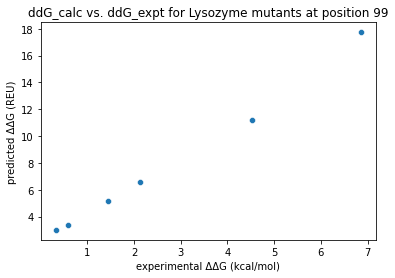

In [32]:
%matplotlib inline

dataset = (pd.read_csv('cartesian_ddg_lysozyme.csv')
           .assign(position=lambda df: df.mutation.apply(lambda row: int(row.split()[2])))
          )
           
ax = sns.scatterplot(data=dataset, x='ddg_expt_protherm', y='ddg_calc')
ax.set(xlabel='experimental ΔΔG (kcal/mol)', ylabel='predicted ΔΔG (REU)')
plt.title('ddG_calc vs. ddG_expt for Lysozyme mutants at position 99')